In [2]:
# Suppress unnecessary warnings so that
# presentation looks clean
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
import emcee
import corner
from scipy import integrate

In [4]:
with open('/Users/johnnosal/GA-DSI-working/week-08/8.2.2-lab-CARTs/code/starter-code/data4.pkl', 'r') as picklefile:
    data2 = pickle.load(picklefile)

In [5]:
data3 = data2[['readmitted','number_inpatient', 'num_lab_procedures', 'num_medications', 'number_diagnoses', 'time_in_hospital', 'number_outpatient', 'num_procedures', 'number_emergency']]

In [6]:
Data3 = data3.as_matrix()

In [7]:
data3.head()

,readmitted,number_inpatient,num_lab_procedures,num_medications,number_diagnoses,time_in_hospital,number_outpatient,num_procedures,number_emergency
0,1,0.226905,-0.681967,-0.175898,0.869955,-0.715412,-0.036208,3.509109,-0.030102
1,1,-0.111221,0.047059,-0.598981,0.869955,-0.503360,19.567446,-0.524282,0.002662
2,0,-0.111221,1.862124,0.008523,0.869955,-0.317815,-0.085340,-0.524282,-0.030102
3,1,-0.223930,-0.557763,-0.338622,-0.370254,1.405105,-0.085340,0.484066,-0.030102
4,0,-0.223930,-1.233987,-0.696615,-0.874089,-0.715412,0.356847,-0.524282,0.002662


In [8]:
#sigmoid
sig = lambda x: 1./(1+np.exp(-x))

# log pred
def lnpred(data, a):
    pairedsum = a[0] + a[1]*data[1] + a[2]*data[2] + a[3]*data[3] + a[4]*data[4] + a[5]*data[5] + a[6]*data[6] + a[7]*data[7] + a[8]*data[8]
    if data[0] == 1:
        return np.log(sig(pairedsum))
    else:
        return np.log(1-sig(pairedsum))

    
    
    # log prior    
def lnprob(a,data):
    A2 = np.sum([e**2 for e in a])
    return -0.5*A2 + np.sum([lnpred(e,a) for e in data])

In [9]:
import random
dataRand = random.sample(Data3,5000) #Take random sample of 5,000 lines from data set

In [10]:
type(dataRand)

list

In [11]:

class BayesReg:
    #Initialize the class - each instance requires a posteriori log function, data set, 
    #number of walkers and number of function parameters
    def __init__(self, post, data, nWalkers, nParameters):
        self.post = post
        self.data = data
        self.nWalkers = nWalkers
        self.nParameters = nParameters

    def BayesTime(self):
        #Moves the walkers and determine parameters and lambda
        p0 = np.random.rand(self.nWalkers*self.nParameters).reshape((self.nWalkers,self.nParameters))
        sampler = emcee.EnsembleSampler(self.nWalkers, self.nParameters, self.post)
        pos, prob, state = sampler.run_mcmc(p0, 1000)
        sampler.reset() #Burns off the first 1000 steps - part of best practice
        pos, prob, state = sampler.run_mcmc(pos, 5000) #Variable number of steps for each walker
        samples = sampler.flatchain
        self.samples = samples
        N = len(samples)
        
        global omega0, omega1, omega2, omega3, omega4, omega5, omega6, omega7, omega8, samples #makes the variables global and usable outside the function
        omega0 = 1/float(N)*sum([e[0] for e in samples])
        omega1 = 1/float(N)*sum([e[1] for e in samples])
        omega2 = 1/float(N)*sum([e[2] for e in samples])
        omega3 = 1/float(N)*sum([e[3] for e in samples])
        omega4 = 1/float(N)*sum([e[4] for e in samples])
        omega5 = 1/float(N)*sum([e[5] for e in samples])
        omega6 = 1/float(N)*sum([e[6] for e in samples])
        omega7 = 1/float(N)*sum([e[7] for e in samples])
        omega8 = 1/float(N)*sum([e[8] for e in samples])
        print ('Omega0 = {0}, Omega1 = {1}, Omega2 = {2}, Omega3 = {3}, Omega4 = {4}, Omega5 = {5}, Omega6 = {6}, Omega7 = {7}, Omega8 = {8}'.format(omega0, omega1, omega2, omega3, omega4, omega5, omega6, omega7, omega8))





In [12]:
diab = BayesReg(lambda a: lnprob(a, dataRand), dataRand, 20, 9) #New instance of Class BayesReg called 'tide' - lnprob function is the posterior, data is data, 40 walkers, and four function parameters
diab.BayesTime()

Omega0 = -0.486451365397, Omega1 = 1.20659118796, Omega2 = 0.110105871333, Omega3 = 0.00796634190396, Omega4 = 0.21752868964, Omega5 = 0.0449997349062, Omega6 = 0.168759139336, Omega7 = -0.0750926032889, Omega8 = 1.01372936537


In [13]:
def MonteCarlo(f, samples):
    N = len(samples)
    return 1/float(N)*sum([f(e) for e in samples])

In [14]:
def predictive(a,data):  # a = omegas, data = row of data
    g = a[0] + a[1]*data[1] + a[2]*data[2] + a[3]*data[3] + a[4]*data[4] + a[5]*data[5] + a[6]*data[6] + a[7]*data[7] + a[8]*data[8]
    return sig(g)

def E(f,samples,row):
    N = len(samples)
    return np.sum([f(s,row) for s in samples])*1./N




In [15]:
predOne = data3[data3.readmitted!=0]
predZero = data3[data3.readmitted!=1]

In [16]:
p1 = predOne.as_matrix()
p0 = predZero.as_matrix()

In [33]:
randp1 = random.sample(p1,3000)
randp0 = random.sample(p0,6000)


In [34]:
randList = randp1 + randp0

In [35]:
len(randList)

9000

In [38]:
g = []
b = []

for i in randList:
    if i[0] == 1:
        g.append(E(predictive,samples,pat))
    else:
        b.append(E(predictive,samples,pat))

In [39]:
np.median(g)

0.25563930096325993

In [40]:
np.median(b)

0.25563930096325993

In [41]:
#Accuracy 

total = sum([1 for x in g if x>= 0.5])
total2 = sum([1 for x in b if x<= 0.5])

print total/float(len(g))
print total2/float(len(b))
print (total + total2)/float(len(g) + len(b))

0.0
1.0
0.666666666667


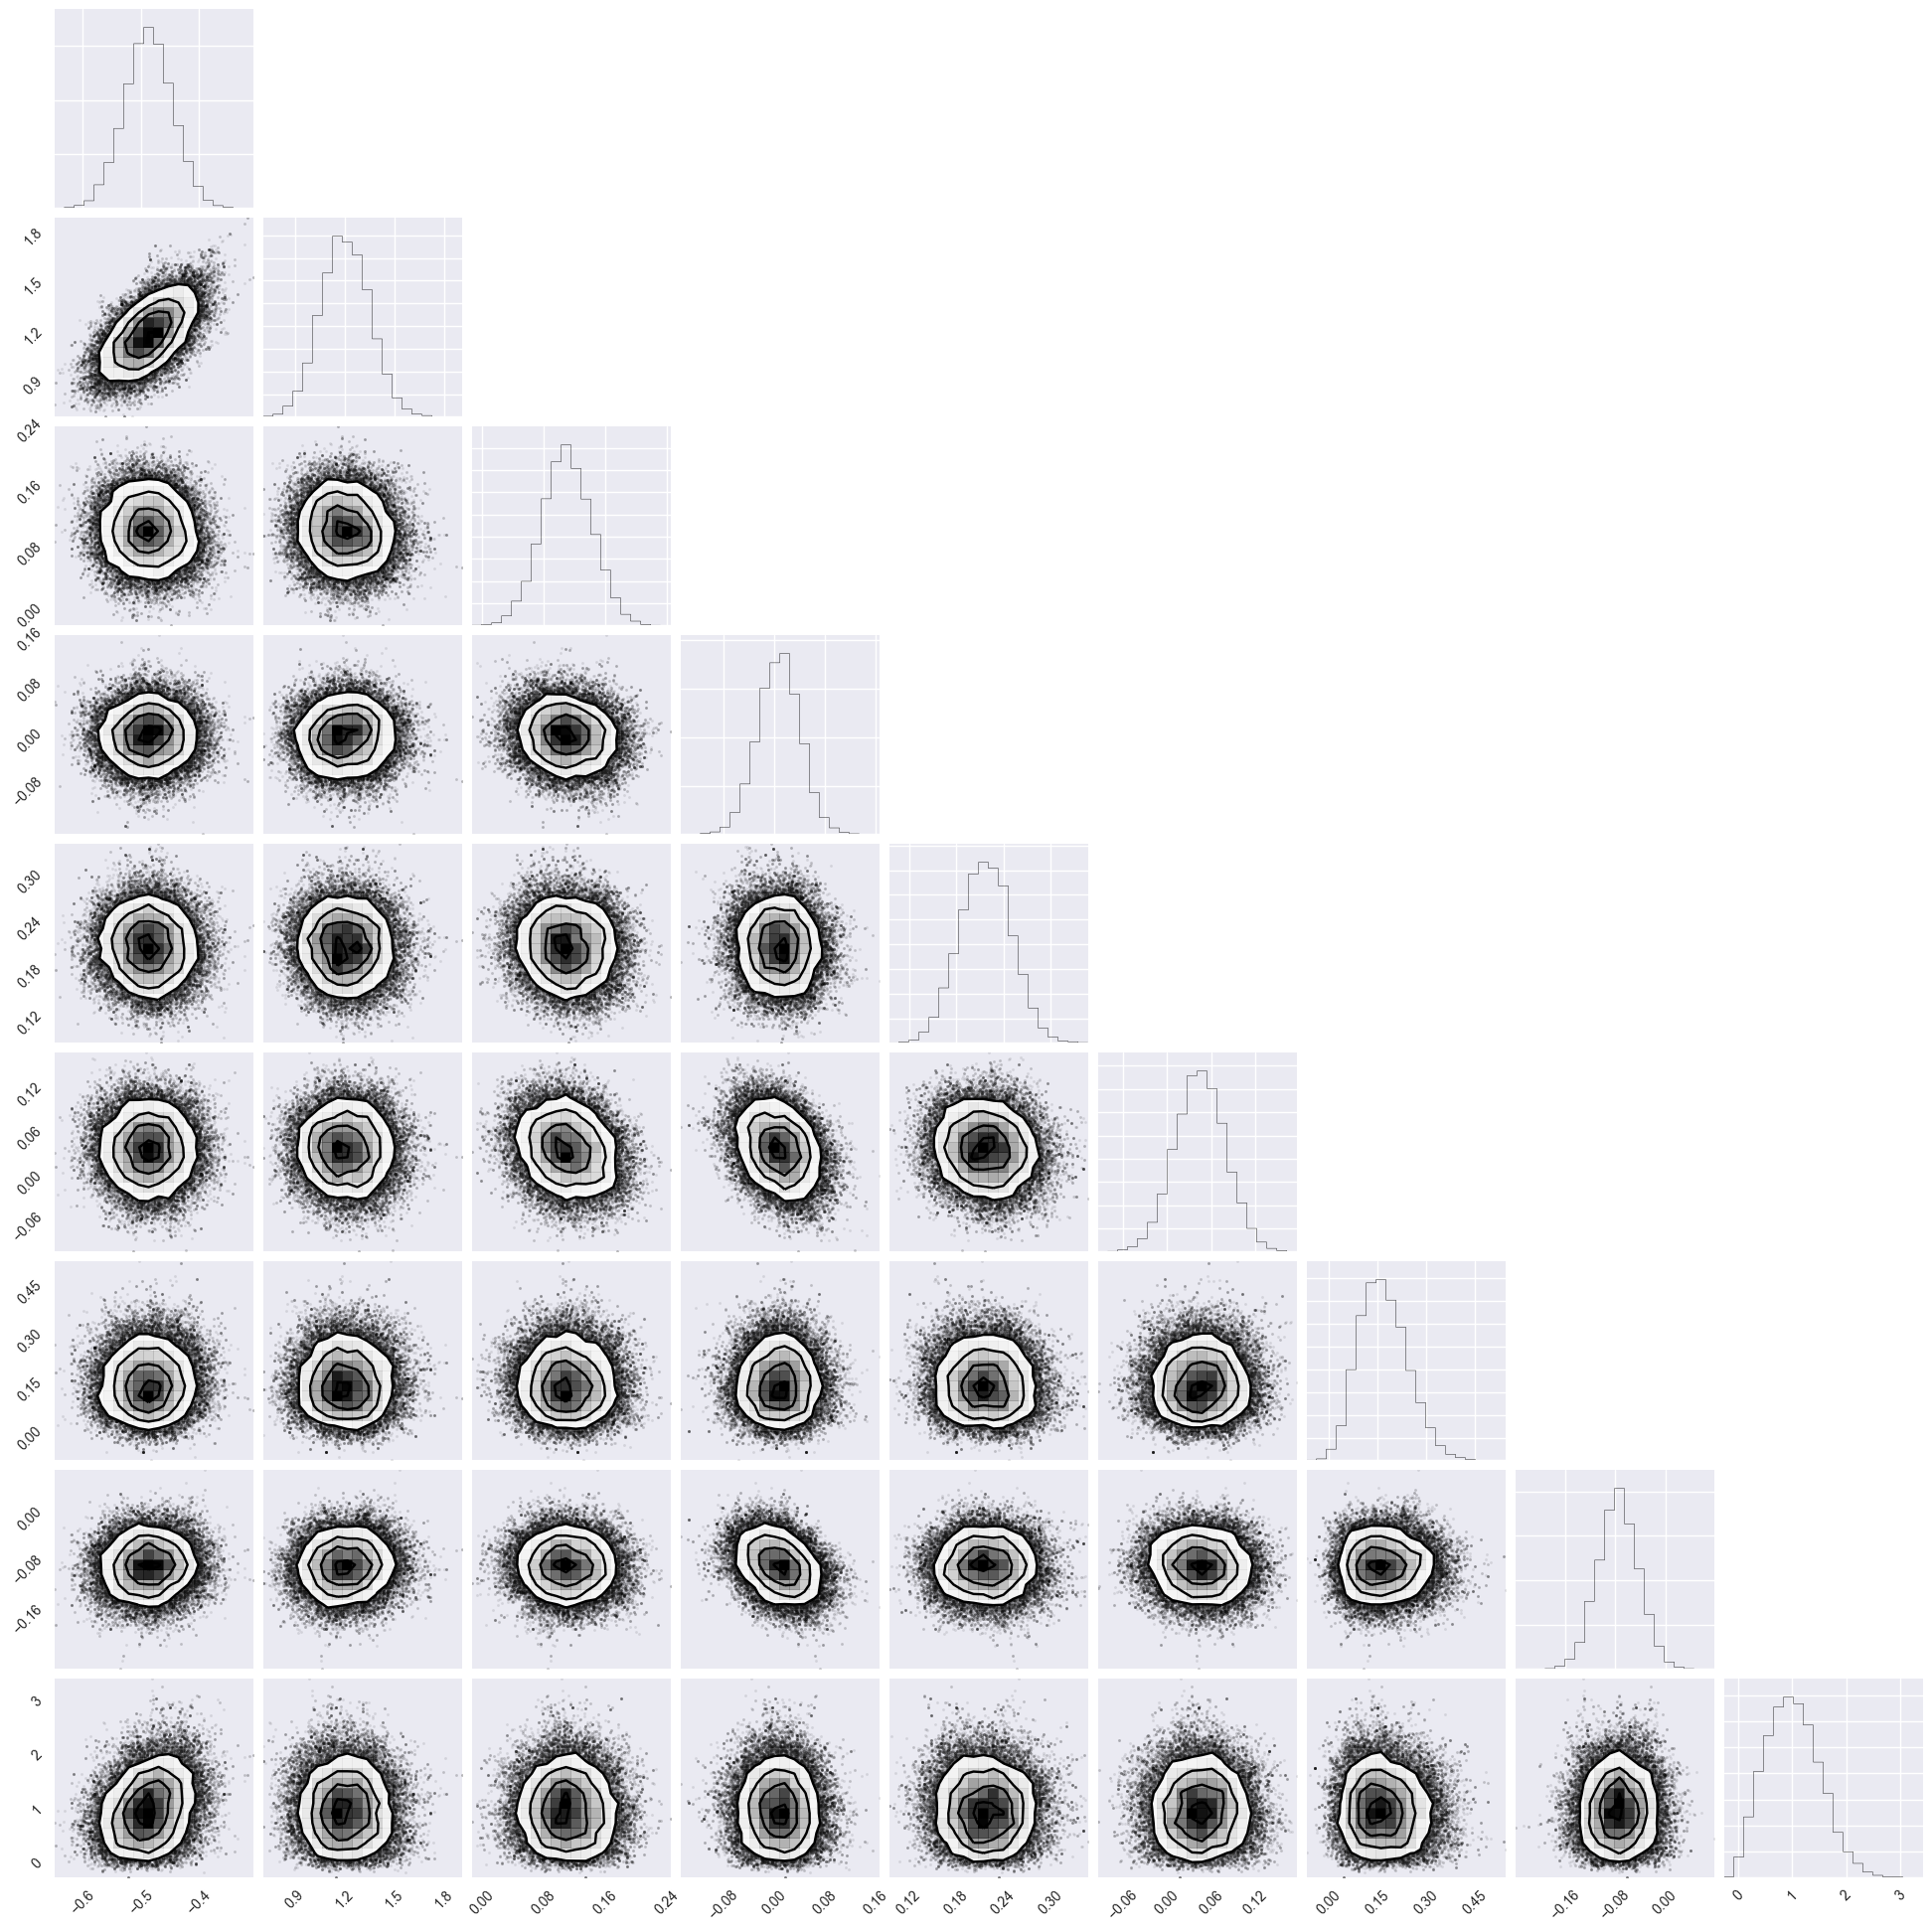

In [25]:
fig = corner.corner(samples)

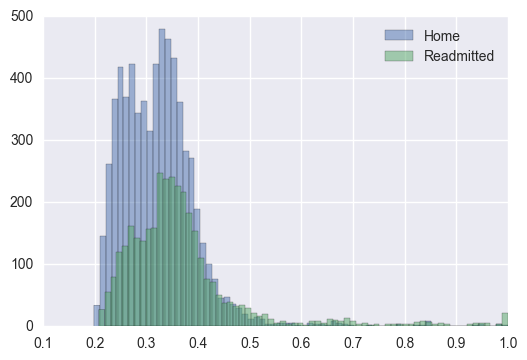

In [121]:
plt.hist(b, bins = 70, alpha=0.5, label = 'Home');
plt.hist(g, bins = 70, alpha=0.5, label = 'Readmitted');
plt.legend();

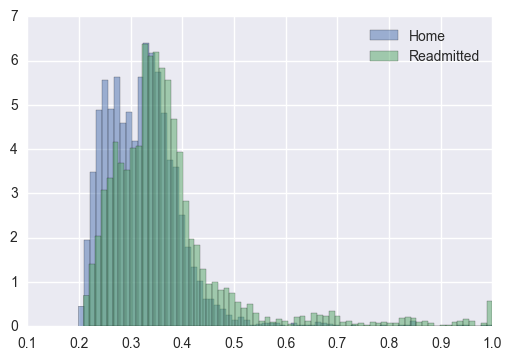

In [122]:
plt.hist(b, bins = 70, alpha=0.5, label = 'Home', normed = True);
plt.hist(g, bins = 70, alpha=0.5, label = 'Readmitted', normed = True);
plt.legend();

# MAP

In [146]:
# find MAP
from scipy.optimize import minimize
rls = lambda a: -lnprob(a, randList)
minRLS = minimize(lambda a: rls(a),[0,0,0,0,0,0,0,0, 0])
minRLS.x

array([-0.42585308,  1.15823548,  0.0932495 , -0.01099367,  0.23014643,
        0.05846954,  0.19392542, -0.01437306,  1.81166613])

In [147]:
# get MAP probability based on scaled data
def ppScale(row):
    return sig(minRLS.x[0] + minRLS.x[1]*row[1] + minRLS.x[2]*row[2] + minRLS.x[3]*row[3] + minRLS.x[4]*row[4] + minRLS.x[5]*row[5] + minRLS.x[6]*row[6] + minRLS.x[7]*row[7] + minRLS.x[8]*row[8])

In [148]:
ppScale(randList[0])

0.3149124665069527

In [151]:
hosp = []
home = []

for i in Data3:
    pat = i
    if pat[0] == 1:
        hosp.append(ppScale(pat))
    else:
        home.append(ppScale(pat))

In [152]:
#Accuracy 

totalmap = sum([1 for x in hosp if x>= 0.5])
total2map = sum([1 for x in home if x<= 0.5])

print totalmap/float(len(hosp))
print total2map/float(len(home))
print (totalmap + total2map)/float(len(hosp) + len(home))

0.0994764397906
0.97508765053
0.673996599368
